# Downloading Gist data from the Github API

In [1]:
    from toolz.curried import *
    from pandas import Series, DataFrame, concat, get_dummies, TimeGrouper

cache the `pandas.read_json` function because that is how we will download the results.  Be aware, resetting `read_json` will clear the cache.

In [10]:
    read_json = memoize(__import__('pandas').read_json)

Begin downloading the data through the Github user information.

In [11]:
    def get_info(user = 'tonyfast'):
        return concat({user: 
                       read_json(f"""https://api.github.com/users/{user}""", typ='series')
                      }).unstack()


From the info we can determine the location and quantity of the user's gists.

In [ ]:
    def get_gists(info, max=3):
        gist_page_url = info.loc["gists_url"].format(**{"/gist_id": "?page={}"}).format

        return (
            concat(
                [
                    read_json(gist_page_url(object))
                    for object in range(1, min(max, (info.loc["public_gists"] // 30) + 1))
                ]
            )
            .pipe(
                lambda df: df["files"]
                .apply(compose(Series, list, dict.values))
                .stack()
                .apply(Series)
                .reset_index(-1, drop=True)
                .join(df)
            )
            .pipe(do(cleanse)).pipe(convert_to_feather, f"{info.name}_gists.feather")
        )


    def cleanse(df):
        """files and owner are dict's that cannot be serialized by feather"""
        del df["files"], df["owner"]


Storing the data in [feather](https://github.com/wesm/feather) makes it more reusable.

In [ ]:
    def convert_to_feather(df, dest):
        import feather
        feather.write_dataframe(df, dest)
        return feather.read_dataframe(dest)

## The `main` function

In [14]:
    def main(user="tonyfast", max=3):
        return get_gists(get_info(user).loc[user], max)

Demonstrate the functions use.

,filename,type,language,raw_url,size,comments,comments_url,commits_url,created_at,description,...,git_pull_url,git_push_url,html_url,id,node_id,public,truncated,updated_at,url,user
2554,Untitled279.ipynb,text/plain,Jupyter Notebook,https://gist.githubusercontent.com/tonyfast/a4...,1928,0,https://api.github.com/gists/748a91e1769d24979...,https://api.github.com/gists/748a91e1769d24979...,2015-12-29 13:51:19,Underlay an svg element as a <div> background,...,https://gist.github.com/748a91e1769d24979393.git,https://gist.github.com/748a91e1769d24979393.git,https://gist.github.com/748a91e1769d24979393,748a91e1769d24979393,MDQ6R2lzdDc0OGE5MWUxNzY5ZDI0OTc5Mzkz,True,False,2015-12-29 13:51:19,https://api.github.com/gists/748a91e1769d24979393,NaN
8969,Untitled144.ipynb,text/plain,Jupyter Notebook,https://gist.githubusercontent.com/tonyfast/0c...,3753,0,https://api.github.com/gists/b0125d860d5ffe74d...,https://api.github.com/gists/b0125d860d5ffe74d...,2016-02-03 17:58:58,A simple dropdown widget,...,https://gist.github.com/b0125d860d5ffe74dbdb.git,https://gist.github.com/b0125d860d5ffe74dbdb.git,https://gist.github.com/b0125d860d5ffe74dbdb,b0125d860d5ffe74dbdb,MDQ6R2lzdGIwMTI1ZDg2MGQ1ZmZlNzRkYmRi,True,False,2016-02-03 17:58:59,https://api.github.com/gists/b0125d860d5ffe74dbdb,NaN


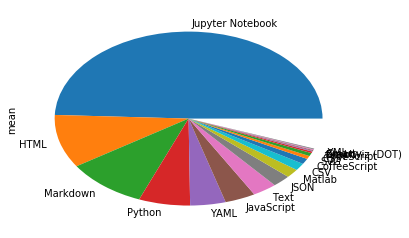

In [23]:
    if 0: 
        df = main(max= 1000)
        %matplotlib inline
        df.set_index('created_at').language.pipe(get_dummies).describe().sort_values('mean', axis=1, ascending=False).loc['mean'].plot.pie()
        __import__("IPython").display.display(df.sample(2))